
<h1><center> Policy Gradients in PyTorch using Neural Networks</center></h1>

This is a naive implementation of Deep Deterministic Policy Gradients (DDPG). The algorithm makes use of Artificial Neural Networks (ANNs) which we will be replacing with CNNs and CapsNet in our future tutorials. We can use this notebook for our reference. The last section consists of all the resources which will come in handy for Reinforcement Learning. 

### 1. Import Dependencies

We will use PyTorch and gym (by OpenAI) for our experiments as these are lightweight and easy to program.

In [0]:
#!pip install gym
import math
import random
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
import matplotlib.pyplot as plt

#Use GPU
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

### 2. Experience Replay Buffer

Almost all Reinforcement Learning methods make use of a Replay Buffer which saves past experiences from a particular episode. Each (state,action,reward,next_state) tuple is stored in the buffer so that the RL algorithm can be trained later when the episode is over.

In [0]:
class ReplayBuffer:
  def __init__(self,capacity): #Initializa Buffer
    self.capacity = capacity
    self.buffer = []
    self.position = 0

  def push(self,state,action,reward,next_state,done): #Push values into buffer
    if len(self.buffer)<self.capacity:
      self.buffer.append(None)
    self.buffer[self.position] = (state,action,reward,next_state,done)
    self.position = (self.position+1)%self.capacity

  def sample(self,batch_size): #Sample values from buffer during training
    batch = random.sample(self.buffer,batch_size)
    state,action,reward,next_state,done = map(np.stack, zip(*batch))
    return state,action,reward,next_state,done

  def __len__(self):
    return len(self.buffer)

### 3. Ornstein-Uhlenbeck Process

Policy Gradient methods require a random process for making the policy explore the game environment. If sufficient exploration is not carried then our agent will not be able to perform all the actions and may fail in cases where it has not encountered a particular state previously. We use the OU process because it is Gaussian, Markovian and temporarily homogenous in nature. 


In [0]:
class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = 6#action_space.shape[0]
        self.low          = 0#action_space.low
        self.high         = 5#action_space.high
        self.reset()
        
    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu
        
    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state
    
    def get_action(self, action, t=0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)

### 4. Actor-Critic Networks

This is where the fun starts! Each Policy Gradient method consists of an Actor Network and a Critic Network. Following are the explanation of the two- 

### 4.1 Actor Network
The Actor Network is responsible for performing the actions during the game. It takes its input as one frame (which is an image) from the game screen and outputs the probabilities for actions. Action corresponding to the highest probability is selected. Actor Networks are often called Policy Networks since they execute the policy which our agent will follow. 

$$ s \rightarrow \pi (a|s,\theta=w)$$

### 4.2 Critic Network
The Critic Network (also called the Value Network) is the one which assesses how good the action was. It takes its input as the state and action performed in that state and outputs the value corresponding to the value function. This value is an indication of how the good the action was and how much it deviates from the ideal action (corresponding to the expected value) in the given state. 

$$ s,a \rightarrow \hat{v}(s,w)$$


In [0]:
class ValueNetwork(nn.Module):
  def __init__(self,num_inputs,num_actions,hidden_size,init_w=3e-3): #The Critic Network
    super(ValueNetwork,self).__init__()
    self.linear1 = nn.Linear(num_inputs+num_actions,hidden_size)
    self.linear2 = nn.Linear(hidden_size,hidden_size)
    self.linear3 = nn.Linear(hidden_size,1)
    self.linear3.weight.data.uniform_(-init_w,init_w)
    self.linear3.bias.data.uniform_(-init_w,init_w)

  def forward(self,state,action): #Forward Pass
    x = torch.cat([state,action],1)
    x = F.relu(self.linear1(x))
    x = F.relu(self.linear2(x))
    x = self.linear3(x)
    return x

class PolicyNetwork(nn.Module): #The Actor Network
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(PolicyNetwork, self).__init__()   
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, num_actions)
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state): #Forward Pass
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = F.tanh(self.linear3(x))
        return x

    def get_action(self,state): #Sample Action
      state = torch.FloatTensor(state).unsqueeze(0).to(device)
      action = self.forward(state)
      return action.detach().cpu().numpy()[0,0]


### 5. DDPG Update

The policy update is carried out by updating the action and value obtained from both the networks. Think of it as updating gradients for a network but in a different way. Here is how one single pass is carried out- 

$\rightarrow$ Randomly initialize Critic Network $\hat{v}(s,w)$ and Actor Network $\pi (a|s,\theta=w)$. 

$\rightarrow$ Initialize target networks $\hat{v}_{'}(s,w)$ and $\pi_{'} (a|s,\theta=w)$. [Target Networks are the networks which keep track of the policy by following similar actions which the original networks performed.] 

$\rightarrow$ Initialize Replay Buffer 'R'

$\rightarrow$ Initialize the OU Process

$\rightarrow$ for episode =1,...M do

$\rightarrow$ for t =1,...T do

$.$    $\small\qquad sample\ state\ s_{t}\ from\ replay\ buffer$

$.$    $\small\qquad select\ action\ a_{t}\ $

$.$    $\small\qquad execute\ a_{t}\ and\ observe\ r_{t}\ , \ s_{t+1} $

$.$    $\small\qquad store\ (s_{t},a_{t},r_{t},s_{t+1})\ in\ R$

$.$    $\small\qquad sample\ a\ mini-batch\ from\ R$

$.$    $\small\qquad set\ y_{i} \leftarrow r_{i} + \gamma \hat{v}_{'}(s_{t+1},w|a_{t})$

$.$    $\small\qquad Update\ Critic:\ L \leftarrow \frac{1}{N}\sum_{i}(y_{i} - \hat{v}_{'}(s_{t},a_{t}|w))^2 $

$.$    $\small\qquad Update\ Actor:\ \nabla_{w}J \leftarrow \frac{1}{N}\sum_{i} (\nabla_{a}\hat{v}_{'}(s_{i=t},a_{t}|w).\nabla_{w}a_{i=t}(s_{i=t}|w))  $

$.$    $\small\qquad Update\ Target\ Networks:\ w \leftarrow \tau w + \tau(1-w) $

$\rightarrow$ endfor

$\rightarrow$ endfor








In [0]:
def ddpg_update(batch_size,gamma=0.99,min_value=-np.inf,max_value=np.inf,soft_tau=1e-2): #One Pass of DDPG update
  state,action,reward,next_state,done = replay_buffer.sample(batch_size) #Sample from Replay Buffer

  state = torch.FloatTensor(state).to(device) #Make Tensors, duh!
  next_state = torch.FloatTensor(next_state).to(device)
  action = torch.FloatTensor(action).to(device)
  reward = torch.FloatTensor(reward).unsqueeze(1).to(device)
  done = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(device)

  policy_loss = value_net(state,policy_net(state)) #Evaluate Critic Loss
  policy_loss = -policy_loss.mean()

  next_action = target_policy_net(next_state) #Predict next action using target actor network
  target_value = target_value_net(next_state,next_action.detach()) #Obtain target value
  expected_value = reward + (1-done)*gamma*target_value #Expected value (taking into account long-term gain)
  expected_value = torch.clamp(expected_value,min_value,max_value)

  action = action.reshape(-1)
  action = action.to('cpu').numpy()
  action = action.astype(int)
  action = np.eye(action_dim)[action]
  action = torch.FloatTensor(action).to(device)
  value = value_net(state,action) #Input action and state to obtain value from Critic
  value_loss = value_critierion(value,expected_value.detach())

  policy_optimizer.zero_grad() #Optimize Actor Network
  policy_loss.backward()
  policy_optimizer.step()

  value_optimizer.zero_grad() #Optimize Critic Network
  value_loss.backward()
  value_optimizer.step()

  for target_param, param in zip(target_value_net.parameters(), value_net.parameters()): #Update Target Value Network
    target_param.data.copy_(target_param.data * (1.0 - soft_tau) + param.data * soft_tau)

  for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()): #Update Target Actor Network
    target_param.data.copy_(target_param.data * (1.0 - soft_tau) + param.data * soft_tau)

### 6. Test DDPG

This is where we run the code. We initialize our environment and the networks and for each step, we proceed in the game by carrying out a sequence of actions. Once our agent loses, the episode ends. In each time-step, the policy $\pi (a|s,\theta=w)$ is improved by updating the actor network. 

Value Network is updated in the following manner- 

\begin{gather}
y_{i} \leftarrow r_{i} + \gamma \hat{v}_{'}(s_{t+1},w|a_{t})
\end{gather}

However, the next-state values are calculated with target value network and the target policy network- 

\begin{gather}
L \leftarrow \frac{1}{N}\sum_{i}(y_{i} - \hat{v}_{'}(s_{t},a_{t}|w))^2
\end{gather}

The objective is to maximize the expected return, 

\begin{gather}
J(w) = \mathbb{E}[\hat{v}(s_{t},a_{t})_{s=s_{t},a=a_{t}}] \\
and,\quad  \nabla_{w}J = \nabla_{a}\hat{v}(s_{t},a_{t}).\nabla_{w}a(s|w) \\
\nabla_{w}J = \frac{1}{N}\sum_{i} (\nabla_{a}\hat{v}_{'}(s_{i=t},a_{t}|w).\nabla_{w}a_{i=t}(s_{i=t}|w))
\end{gather}



/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


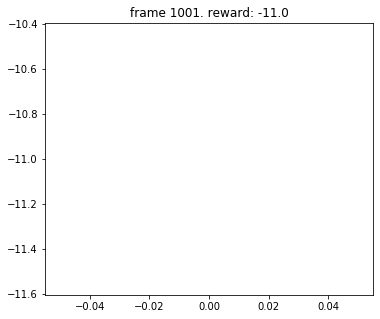

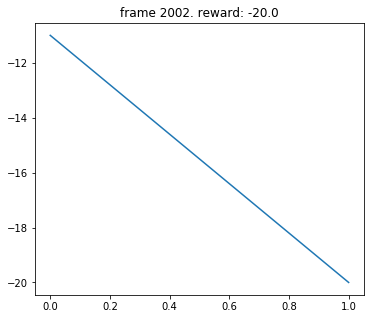

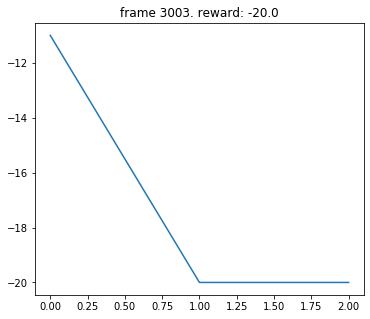

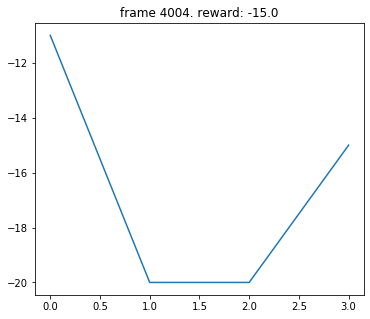

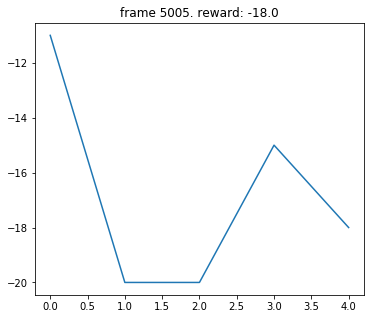

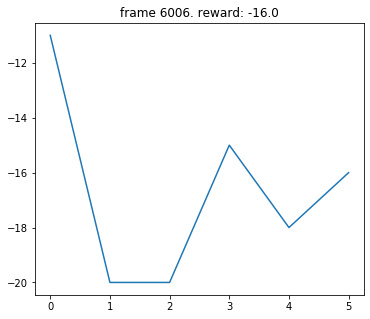

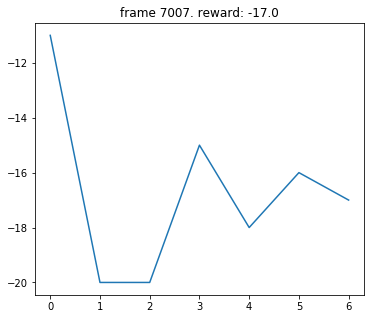

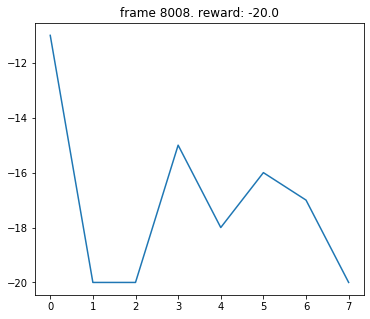

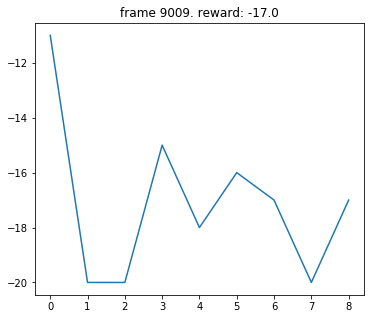

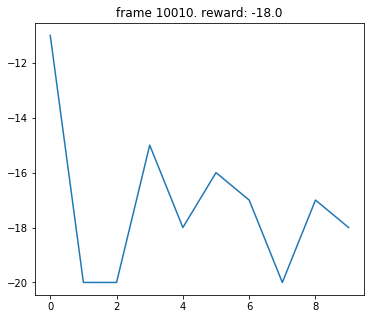

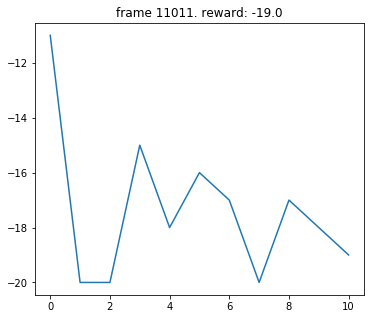

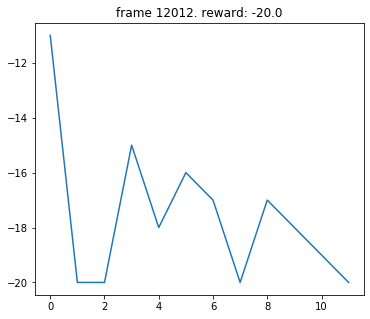

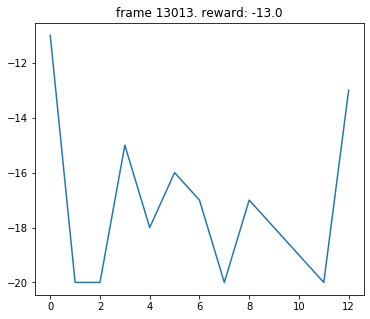

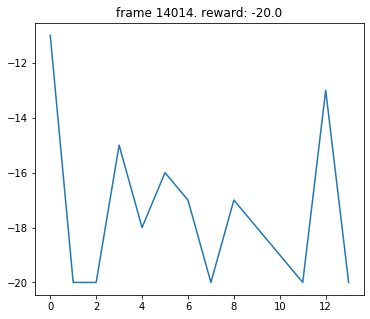

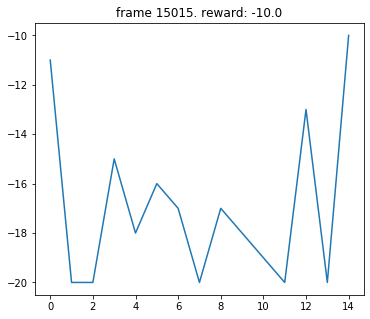

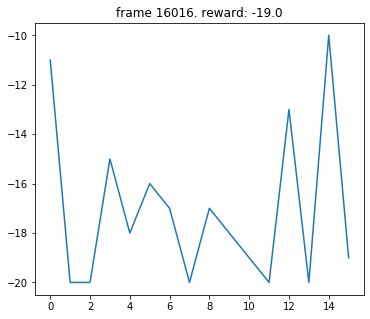

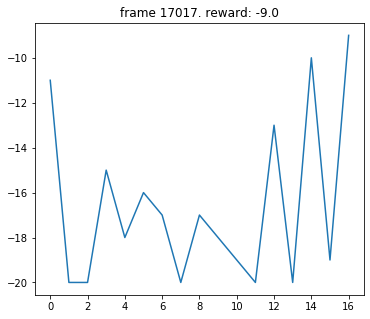

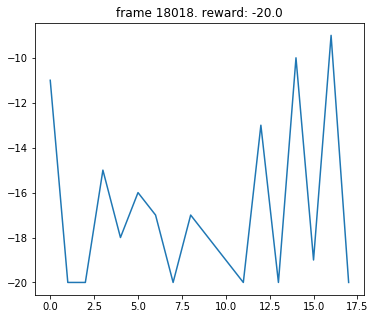

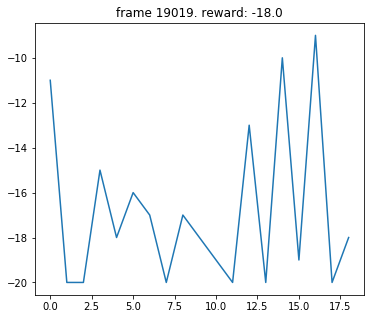

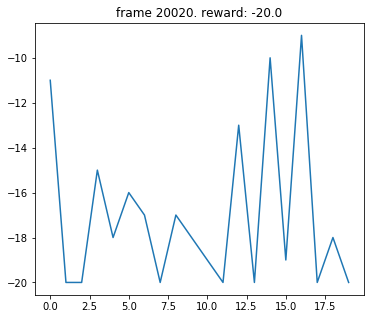

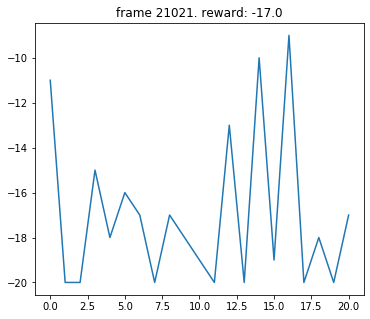

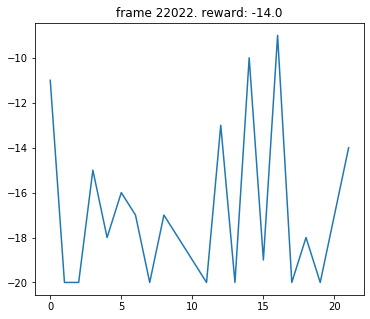

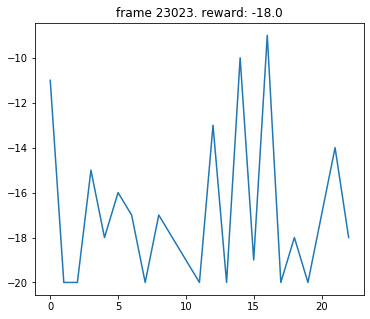

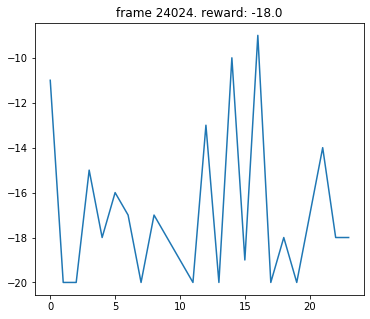

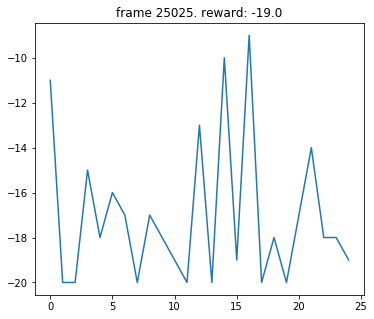

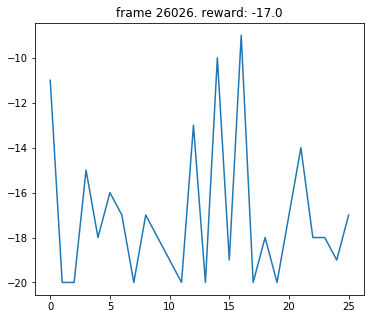

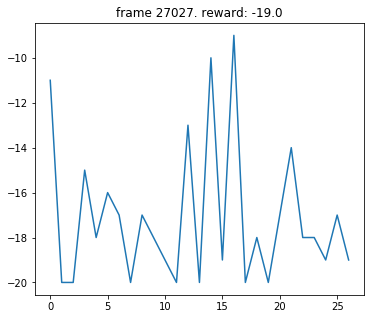

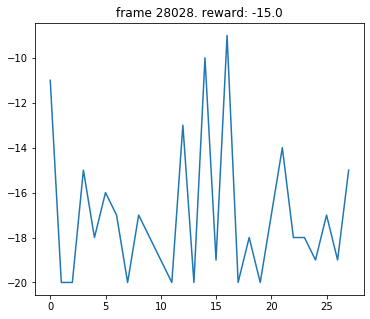

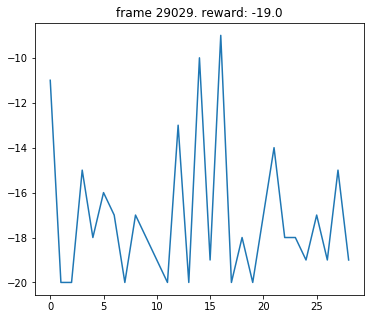

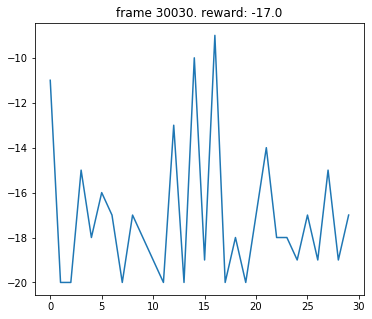

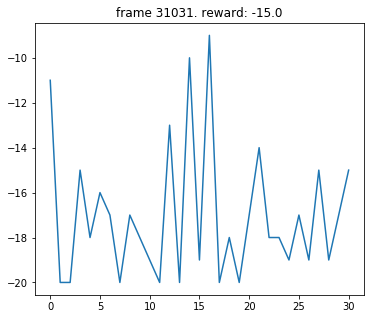

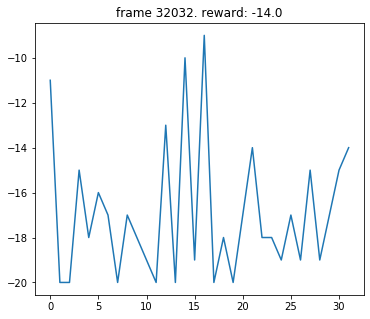

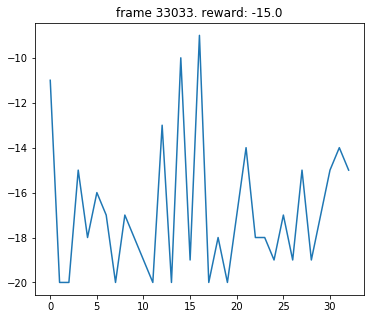

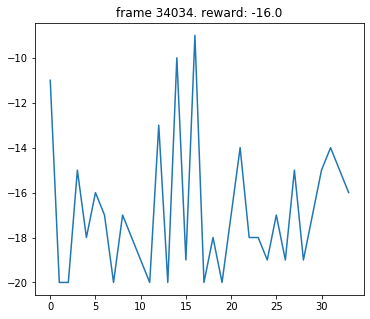

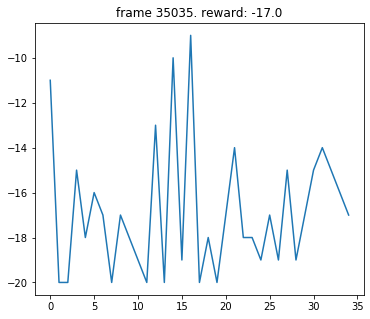

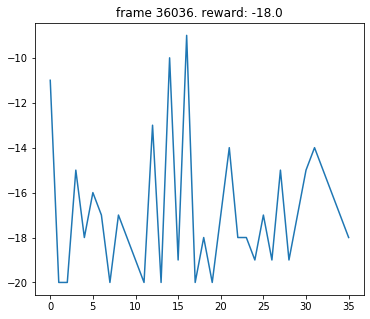

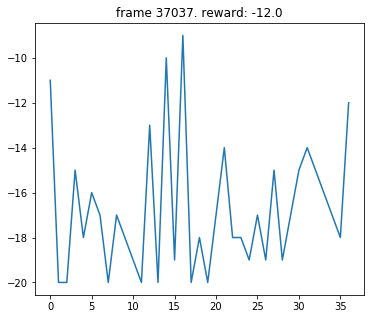

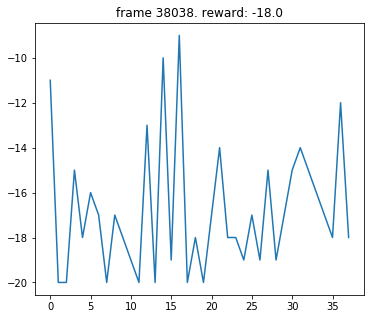

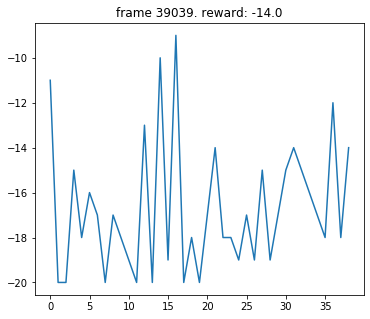

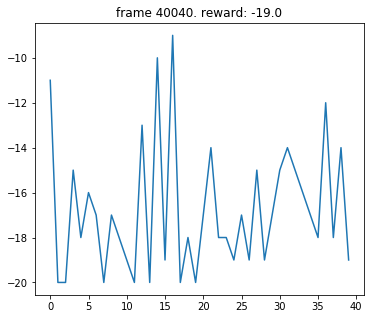

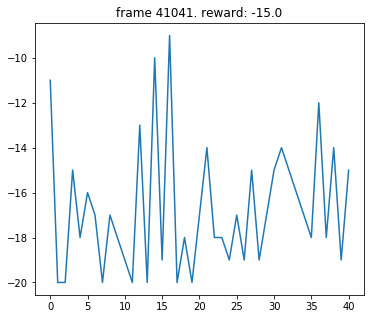

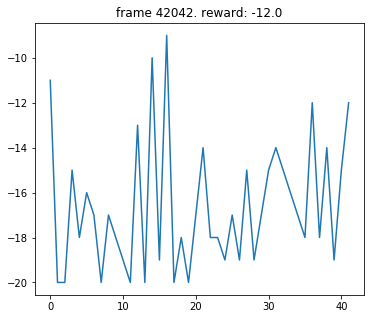

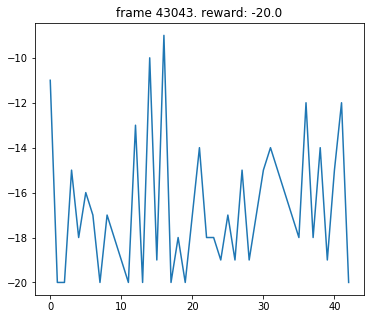

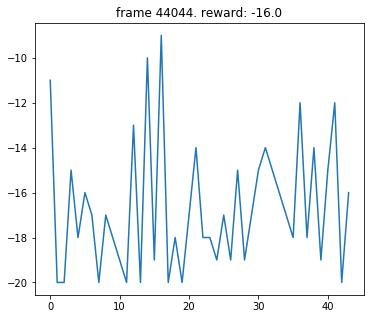

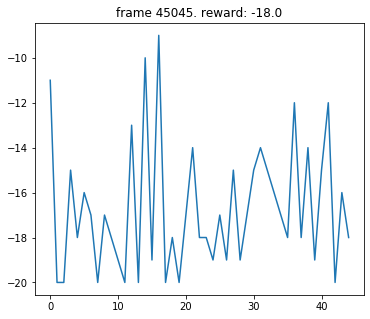

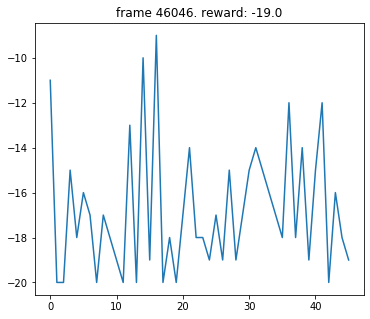

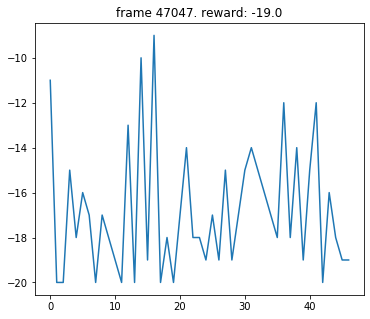

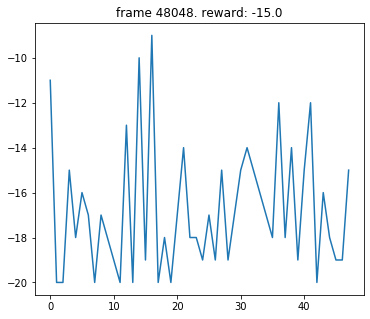

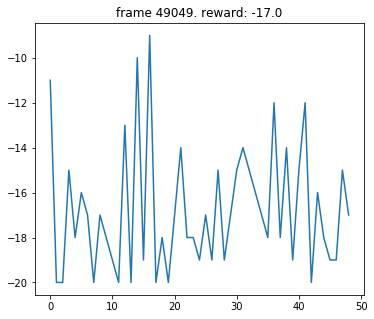

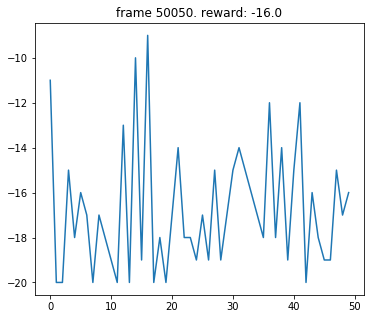

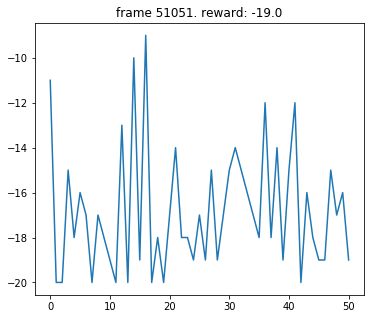

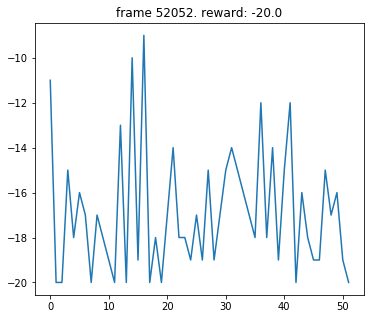

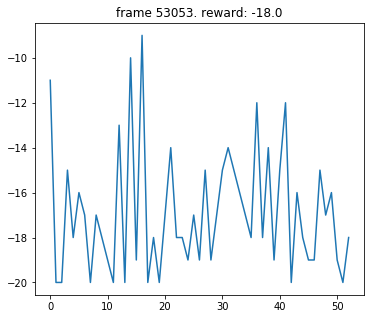

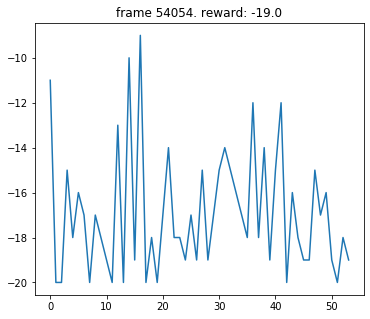

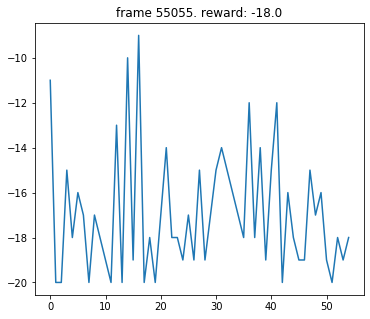

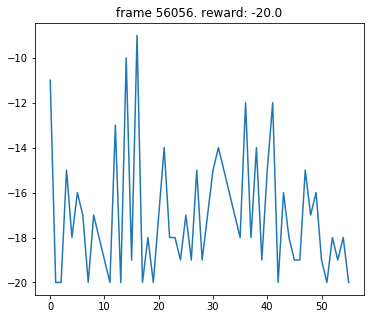

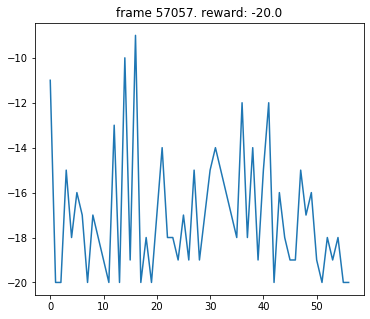

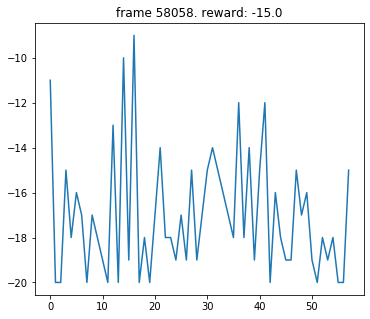

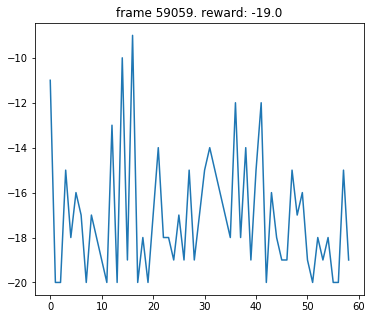

In [0]:
def preprocess(I): #Preprocess the Image
  I = I[35:95] #Crop
  I = I[::2,::2,0]
  I[I == 144] = 0 #Remove background
  I[I == 109] = 0 
  I[I != 0] = 1 
  return I.astype(np.float).ravel()

D = 2400 #Number of pixels

env = gym.make('Pong-v0') #Make the Environment
ou_noise = OUNoise(env) #Initialize OU Process

state_dim = D #env.observation_space.shape[0]
action_dim = 6 #Number of actions
hidden_dim = 2048 #Number of hidden units

value_net = ValueNetwork(state_dim,action_dim,hidden_dim).to(device) #Initialize Value Network
policy_net = PolicyNetwork(state_dim,action_dim,hidden_dim).to(device) #Initialize Actor Network

target_value_net = ValueNetwork(state_dim,action_dim,hidden_dim).to(device) #Initialize Target Value Network
target_policy_net = PolicyNetwork(state_dim,action_dim,hidden_dim).to(device) #Initialize Target Actor Network

for target_param,param in zip(target_value_net.parameters(),value_net.parameters()): 
  target_param.data.copy_(param.data)

for target_param,param in zip(target_policy_net.parameters(),policy_net.parameters()):
  target_param.data.copy_(param.data)

value_lr = 1e-3
policy_lr = 1e-4

value_optimizer = optim.Adam(value_net.parameters(),lr=value_lr)
policy_optimizer = optim.Adam(policy_net.parameters(),lr=policy_lr)

value_critierion = nn.MSELoss()

replay_buffer_size = 1000000
replay_buffer = ReplayBuffer(replay_buffer_size) #Initialize Replay Buffer

max_frames  = 60000 #Frames
max_steps   = 1000 #Steps
frame_idx   = 0
rewards     = []
batch_size  = 128

def plot(frame_idx, rewards): #Plot rewards over episodes
    #clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()

while frame_idx<max_frames:
  prev_state = None
  state = env.reset() #Reset the Environment
  ou_noise.reset()
  episode_reward = 0

  for step in range(max_steps): #Iterate over steps
    #plt.figure()
    #plt.imshow(state) #Plot frames from the game screen
    state = preprocess(state) #Process the current state as input image
    state = state - prev_state if prev_state is not None else np.zeros(D) #Difference image
    prev_state = state
    action = policy_net.get_action(state) #Sample action from Actor Network
    action = ou_noise.get_action(action,step) #Apply OU Process
    action = np.argmax(action, axis=0) #Select the best action
    next_state,reward,done,_ = env.step(action) #Execute action and observe next_state,reward
    n_state = preprocess(next_state) #Porcess next_state as image

    replay_buffer.push(state,action,reward,n_state,done) #Push values to buffer
    if len(replay_buffer)>batch_size:
      ddpg_update(batch_size) #Perform DDPG update

    state = next_state 
    episode_reward += reward #Increment reward
    frame_idx += 1

    if frame_idx % max(1000,max_steps+1)==0: #Plot framesper 1000 steps
      plot(frame_idx,rewards)
      pass

    if done:
      break
  rewards.append(episode_reward) #Store rewards


### 7. Useful Resources

1. DDPG Paper- https://arxiv.org/abs/1509.02971
2. Q-Learning Paper- https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf
3. Coursera- https://www.coursera.org/specializations/reinforcement-learning
4. Policy Gradient Paper- http://proceedings.mlr.press/v32/silver14.pdf
5. TowardsDataScience- https://towardsdatascience.com/deep-deterministic-policy-gradients-explained-2d94655a9b7b
6. RL-Adventure (one of my favourite Github repositories)- https://github.com/higgsfield/RL-Adventure-2
